# CEEL82B Expt 3: Data Classification

### Objectives
(i) Apply Naive bayes classifier for given data see Naive_bayes_handout.zip file in edmodo.

(ii) Apply and compare Linear Discriminating Analysis with Naive bayes classifiers w.r.t. error, specificity and sensitivity


### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,classification_report, roc_curve, auc
from nltk import PorterStemmer as Stemmer
%matplotlib inline

### Reading  the dataset

In [2]:
df = pd.read_csv('spam.csv')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Our dataset has a total of 5572 SMS

### Data Cleaning 

We observe that the dataset is not read properly, and there are unnecessary extra columns with neglegible values, hence we remove the extra columns and rename the columns to their appropriate names

In [4]:
df = df[['v1', 'v2']]
df.columns = ['label', 'message']
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


The dataset has more ham than spam, and we can observe repeated messages with same content

### Exploratory Data Analysis

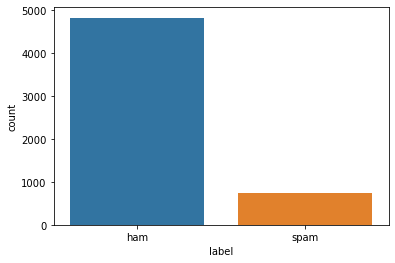

In [7]:
sns.countplot(data=df, x='label')

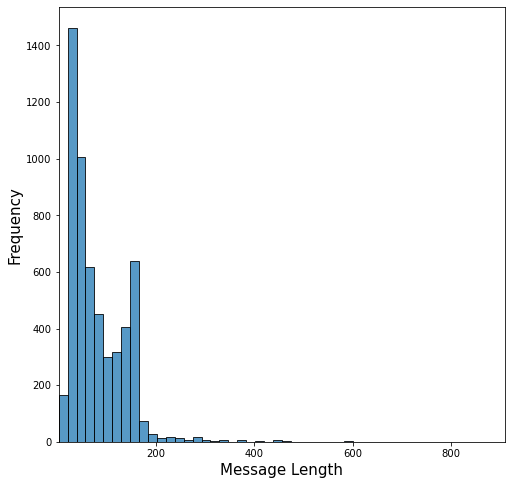

In [8]:
plt.figure(figsize=(8,8))
sns.histplot(df['message'].apply(len), bins=50)
plt.ylabel("Frequency", fontsize = 15)
plt.xlabel("Message Length", fontsize = 15)
plt.margins(x = 0)

* It is highly likely that a message has length less than 200
* We also see that a few messages are very long

Let's now look at the relationship between the length of a message and it's class (ham or spam)

In [9]:
df['length'] = df['message'].apply(len)
df.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


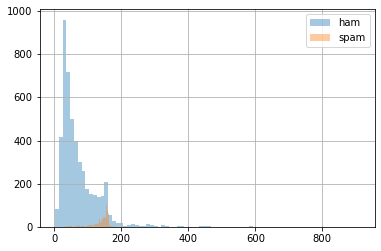

In [10]:
df.groupby("label").length.hist(alpha=0.4, bins=80, legend=True)
plt.show()

We can thus see that the spam messages are typically having a length of about 150-200, whereas, most of the ham messages are having a value between 0-100

### Train Test Split

In [11]:
from sklearn.model_selection import train_test_split
X = df['message']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Data Preprocessing
Before proceeding, we make changes to the original text column of the dataset:
* Remove all the punctutaions 
* Make our 'message' column into lowercase
* Remove the stopwords
* Apply Stemming on the corpus

**CountVectorizer:** Convert a collection of text documents to a matrix of token counts.

If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.

* Count vectorizer automatically performs all the steps of the data preprocessing on the data, and forms the corpus in it's `count_vector` object, so we don't need to.


In [12]:
count_vector = CountVectorizer()

In [13]:
training_data = count_vector.fit_transform(X_train) # Fitting the vectorizer to the training data
testing_data = count_vector.transform(X_test)  # Transforming the training data

In [14]:
count_vector.get_feature_names()[800:810] # Shows all word feature names, 

C:\Users\aurko\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['advise',
 'advisors',
 'aeronautics',
 'aeroplane',
 'affair',
 'affairs',
 'affection',
 'affectionate',
 'affections',
 'afford']

Sparse training matrix

In [15]:
training_data_matrix = training_data.toarray()
training_data_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [16]:
training_data_matrix.shape

(4457, 7580)

The sparse matrix has 4457 rows corresponding to each message in the training data and 7612 columns corresponding to each unique word feature

In [17]:
sparsity = 1.0 - ( training_data.count_nonzero() / float(training_data_matrix.size) )
sparsity

0.9982628494029433

## Naive Bayes Classifier

### Training

In [18]:
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data,y_train)

predictions = naive_bayes.predict(testing_data)

### Evaluation

Specificity: 0.9978925184404637
Sensitivity: 0.9216867469879518


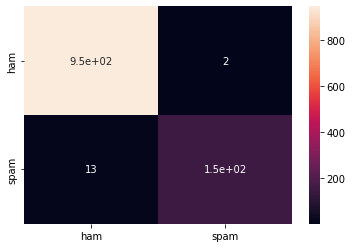

In [19]:
conf_matrix = confusion_matrix(y_test, predictions, labels=naive_bayes.classes_)
tn, fp, fn, tp = conf_matrix.ravel()
print(f'Specificity: {tn/(tn+fp)}')
print(f'Sensitivity: {tp/(tp+fn)}')

sns.heatmap(pd.DataFrame(conf_matrix, index=naive_bayes.classes_,columns=naive_bayes.classes_), annot=True)

In [20]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       949
        spam       0.99      0.92      0.95       166

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



### ROC AUC curve

In [21]:
y_prob = naive_bayes.predict_proba(testing_data.toarray())
y_prob = y_prob[:, 1]

n_classes = len(naive_bayes.classes_)
# 0 ham
# 1 spam
y_true = [0 if i=="ham" else 1 for i in y_test]

fpr, tpr,_ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

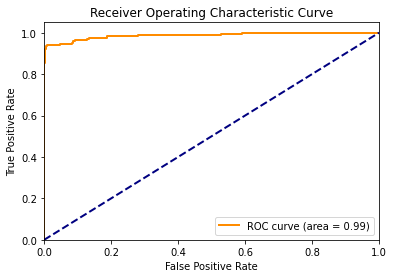

In [22]:
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=n_classes,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=n_classes, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

The above plot shows the ROC plot for Naive Bayes classifier. 
* The area under curve is 0.99 in this case

### Applying naive bayes for a lower dimensional matrix

For example, we reduce the training data to a size of 1000 entries

### Training

In [41]:
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data[:1000],y_train[:1000])

predictions = naive_bayes.predict(testing_data)

### Evaluation

Specificity: 1.0
Sensitivity: 0.7771084337349398


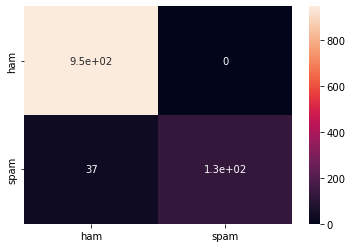

In [42]:
conf_matrix = confusion_matrix(y_test, predictions, labels=naive_bayes.classes_)
tn, fp, fn, tp = conf_matrix.ravel()
print(f'Specificity: {tn/(tn+fp)}')
print(f'Sensitivity: {tp/(tp+fn)}')

sns.heatmap(pd.DataFrame(conf_matrix, index=naive_bayes.classes_,columns=naive_bayes.classes_), annot=True)

In [43]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       949
        spam       1.00      0.78      0.87       166

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



### ROC AUC curve

In [44]:
y_prob = naive_bayes.predict_proba(testing_data.toarray())
y_prob = y_prob[:, 1]

n_classes = len(naive_bayes.classes_)
# 0 ham
# 1 spam
y_true = [0 if i=="ham" else 1 for i in y_test]

fpr, tpr,_ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

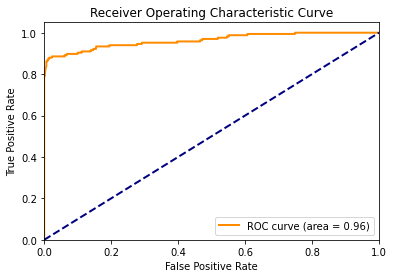

In [45]:
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=n_classes,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=n_classes, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

The above plot shows the ROC plot for Naive Bayes classifier. 
* The area under curve is 0.96 in this case

## Linear Discriminant Analysis

### Training

In [23]:
lda = LinearDiscriminantAnalysis()
lda.fit(training_data.toarray(), y_train)

predictions = lda.predict(testing_data.toarray())

### Evaluation

Specificity: 0.898840885142255
Sensitivity: 0.7228915662650602


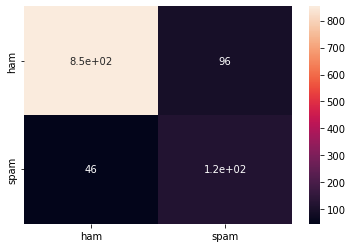

In [24]:
conf_matrix = confusion_matrix(y_test, predictions, labels=lda.classes_)
tn, fp, fn, tp = conf_matrix.ravel()
print(f'Specificity: {tn/(tn+fp)}')
print(f'Sensitivity: {tp/(tp+fn)}')

sns.heatmap(pd.DataFrame(conf_matrix, index=lda.classes_,columns=lda.classes_), annot=True)

In [25]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.95      0.90      0.92       949
        spam       0.56      0.72      0.63       166

    accuracy                           0.87      1115
   macro avg       0.75      0.81      0.78      1115
weighted avg       0.89      0.87      0.88      1115



The overall accuracy has dropped compared to using Naive Bayes approach

### ROC AUC curve

In [26]:
y_prob = lda.predict_proba(testing_data.toarray())
y_prob = y_prob[:, 1]

n_classes = len(lda.classes_)
# 0 ham
# 1 spam
y_true = [0 if i=="ham" else 1 for i in y_test]

fpr, tpr,_ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

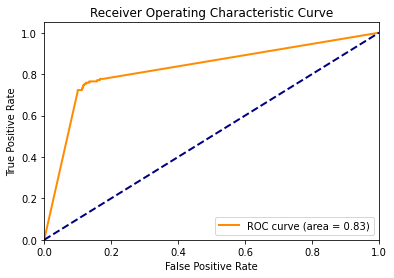

In [27]:
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=n_classes,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=n_classes, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

The above plot shows the ROC plot for LDA classifier. 
* The area under curve is 0.83 in this case

### Conclusion

1. We cleaned the SMS spam dataset, and removed unnecessary columns. We found that fewer than 1000 sms were spam, and the rest around 5000 were ham. 
2. On performing EDA, it was observed that most message lengths are fewer than 200 characters, and the spam messages typically having a length of about 150-200, whereas, most of the ham messages are having a value between 0-100. Applying the CountVectorizer, we simultaneously get the sparse matrix, and the corpus with all the steps of preprocessing done in CountVectorizer like removing all the punctutaions, converting text lowercase, removing the stopwords, apply stemming on the corpus etc.
4. The sparsity of the matrix turned out to be very high, at 99.8%, and using Naive Bayes we got pretty high specificity and Sensitivity between 90-99 %., same can be said about precision, recall and f1-score of Naive Bayes for each class stayed between 0.95-0.99, showing the highest scores for Naive Bayes, signifying less false alarms and less misclassification with an impressive AUC score of 0.99.
5. By reducing the number of training sentences to 1000, we tested the Naive Bayes classifier to compare the results with the result obtained using the full data. We found that the sensitivity dropped significantly, and also there was significant drop in ham's precision, spam's recall, and a uniform decrease in the f1- score for both classes. The class imbalance began affecting the AUC score of Naive Bayes, but on average it performed better than LDA classifier.
6. LDA classifier performed poorly on the dataset as we saw moderate specificity and sensitivity between 70-90%. Since there were many data points for ham, it gets a high precision, recall and f1-score between 0.90-0.99. But, for the case of spam, cause of class imbalance, we see that it performs poorly 0.5-0.7 for the same criteria. Also the AUC is lesser than that of Naive Bayes. Thus it implies more false alarms and misclassification.